# <center> **Classical Regression** </center> 

 - A feed forward neural network is trained ad its architecture is optimized for various datasets
___

In [1]:
import tensorflow as tf

from hyperopt import fmin, tpe, hp, Trials, space_eval, STATUS_OK, STATUS_FAIL

from pickle import dump, load
import gzip

import numpy as np
import pandas as pd
from scipy.stats import binned_statistic as binStats

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

from os import system as runInTerminal

___

In [2]:
RANDSEED = 42

In [16]:
plt.rcParams.update({'figure.figsize': [15.0, 10.0],
                     'figure.dpi' : 300,
                     'font.size': 18.0, 
                     'mathtext.fontset' : 'stix', 
                     'font.family' : 'STIXGeneral'
                    })

___
## Load Dataset

In [70]:
#datasetName = "testDataset_1dim"
#datasetName = "testDataset_2dim"

#datasetName = "housing"
#datasetName = "housing_lessFeatures"

#datasetName = "cars_v3"
#datasetName = "cars_v3_lessFeatures"

#datasetName = "co2_mlo_1var"
datasetName = "co2_mlo_2var"

X_train, y_train, X_val, y_val, X_test, y_test, INPUT_SHAPE = load(gzip.open(f"DatasetsProcessed/{datasetName}", "rb"))

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

___
## Hyperparameters Optimization

In [25]:
def create_model(hiddenLayers=2, nodesPerLayer=64, lastLayerActivation="linear"):
    model = tf.keras.models.Sequential(name="Classical_FFNN")
    model.add(tf.keras.layers.Input(shape=INPUT_SHAPE, name="input"))
    for i in range(hiddenLayers):
        model.add(tf.keras.layers.Dense(nodesPerLayer, activation="relu", name=f"hidden_{i+1}"))
    model.add(tf.keras.layers.Dense(1, activation=lastLayerActivation, name="output"))
    return model

def compile_model(model, learning_rate,  verbose=1):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mse", metrics=["mae"])
    if verbose > 0:
        model.summary()

def fit_model(model, train_ds, val_ds, epochs, verbose=1):
    history = model.fit (train_ds,
                     validation_data=val_ds,
                     epochs=epochs,
                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-6, restore_best_weights=True)],
                     verbose=verbose
                    )
    return history

def hyperopt_func(params):
    layers = int(params["hiddenLayers"])
    nodes = int(params["nodesPerLayer"])
    learning_rate = params["learningRate"]
    activation = params["activationLastLayer"]
    
    print(f"Training Model with:\n\t- {layers} hidden layers\n\t- {nodes} nodes per layer\n\t- learning rate = {learning_rate:.5f}\n\t- last layer activation = {activation}\n\n")
    
    try:
        model = create_model(layers, nodes, lastLayerActivation=activation)
        compile_model(model, learning_rate=learning_rate, verbose=0)
        history = fit_model(model, train_dataset, val_dataset, epochs=1000, verbose=0)
        val_loss = history.history["val_loss"][-1]

        print(f"\nTraining successful: {history.epoch[-1]} epochs, loss={val_loss:.5e}\n\n\n")

        return {"loss" : val_loss, "status" : STATUS_OK, "history" : [history.history], "weights" : [model.get_weights()]}

    except KeyboardInterrupt:
        raise KeyboardInterrupt
    
    except:
        print("Training Failed, next trial\n\n\n")
        return {"status" : STATUS_FAIL}
    
search_space = {
    "hiddenLayers" : 10,
    "nodesPerLayer" : 100,
    "learningRate" : 0.001,
    "activationLastLayer" : "linear" #tried sigmoid also, worse performance
}

In [26]:
search_space.update({
    "hiddenLayers" : hp.quniform("hiddenLayers", 2, 25, 1),
    "nodesPerLayer" : hp.qloguniform("nodesPerLayer", 2, 7, 10),
    "learningRate" : hp.loguniform("learningRate", -10, -2),
})

In [ ]:
# Start a new hyperparameter search (overwrites old trials!!)
#trials = Trials()
# or resume previous one
trials = load(gzip.open(f"Variables/FFNN_Trials/hp_trials_FFNN_{datasetName}", "rb"))


for i in range(len(trials.trials)+1, 501):
    print(f"-------------------    TRIAL {i}/500    -------------------\n\n")
    fmin(hyperopt_func, search_space, algo=tpe.suggest, max_evals=i, trials=trials, show_progressbar=False)
    
    if i==1 or i%3==0:
        print("-----------------------------------------------------------\n\n")
        print("Dumping trials... don't ctrl-c now...", end='')
        dump(trials, gzip.open(f"Variables/FFNN_Trials/hp_trials_FFNN_{datasetName}", "wb"))
        print(" Done!\n\n")

### Hyperparameters search results

In [61]:
#Load trials, get best hyperparameters, trained model and training history

def trials_to_DataFrame(trials, search_space=search_space):

    def unpack(x):
        try:
            return x[0]
        except:
            return x

    
    trials_ok = [trial for trial in trials.trials if trial["result"]["status"] == STATUS_OK]

    lossTrials = pd.DataFrame([trial["result"]["loss"] for trial in trials_ok], columns=["loss"])
    weightsTrials = pd.DataFrame([trial["result"]["weights"] for trial in trials_ok], columns=["weights"])
    historyTrials = pd.DataFrame([trial["result"]["history"] for trial in trials_ok], columns=["history"])
    paramsTrials = pd.DataFrame([trial["misc"]["vals"] for trial in trials_ok], columns=search_space.keys()).applymap(unpack)
    paramsTrials = paramsTrials.T.apply(lambda x: space_eval(search_space, x))
    paramsTrials = pd.DataFrame.from_records(paramsTrials.values)



    trials_df = pd.concat([lossTrials, paramsTrials, weightsTrials, historyTrials], axis=1)
    
    
    #making sure columns are in the correct order and then renaming for better axis labels
    trials_df = trials_df[['loss', 'hiddenLayers', 'nodesPerLayer', 'learningRate', "activationLastLayer", "weights", "history"]]
    trials_df.columns = ["Loss", "Hidden Layers", "Nodes per Layer", "Learning Rate", "Last Layer Activation function", "weights", "history"]
    
    return trials_df

trials = load(gzip.open(f"Variables/FFNN_Trials/hp_trials_FFNN_{datasetName}", "rb"))
trials_df = trials_to_DataFrame(trials)
trials_df["LogLoss"] = np.log(trials_df["Loss"])

#remove outliers
threshold = trials_df["Loss"].mean() + 5 * trials_df["Loss"].std()
trials_df = trials_df[trials_df["Loss"] < threshold]

#### Choose the Best Model
 - best Loss
 - a random one from the trials
 - a specific trial

In [62]:
trials_df.sort_values("Loss")[["Loss","Hidden Layers", "Nodes per Layer", "Learning Rate"]]

,Loss,Hidden Layers,Nodes per Layer,Learning Rate
17,0.000039,5.0,670.0,0.025581
18,0.000047,8.0,200.0,0.000103
19,0.000048,15.0,300.0,0.061794
11,0.000048,22.0,80.0,0.050852
15,0.000050,15.0,50.0,0.000093
5,0.000051,7.0,160.0,0.008199
2,0.000054,20.0,210.0,0.000048
9,0.000062,9.0,50.0,0.017494
4,0.000068,8.0,30.0,0.050421
16,0.000080,4.0,50.0,0.070558


In [63]:
idx_best = trials_df["Loss"].idxmin() #Best Model
#idx_best = np.random.choice(trials_df.index) #Random Trial
#idx_best = 325 # Specific Trial

trials_df.loc[[idx_best]]

,Loss,Hidden Layers,Nodes per Layer,Learning Rate,Last Layer Activation function,weights,history,LogLoss
17,0.000039,5.0,670.0,0.025581,linear,"[[[-0.012594402, -0.026545195, 0.048149686, 0....","{'loss': [0.16112856566905975, 0.0354779474437...",-10.140321


___

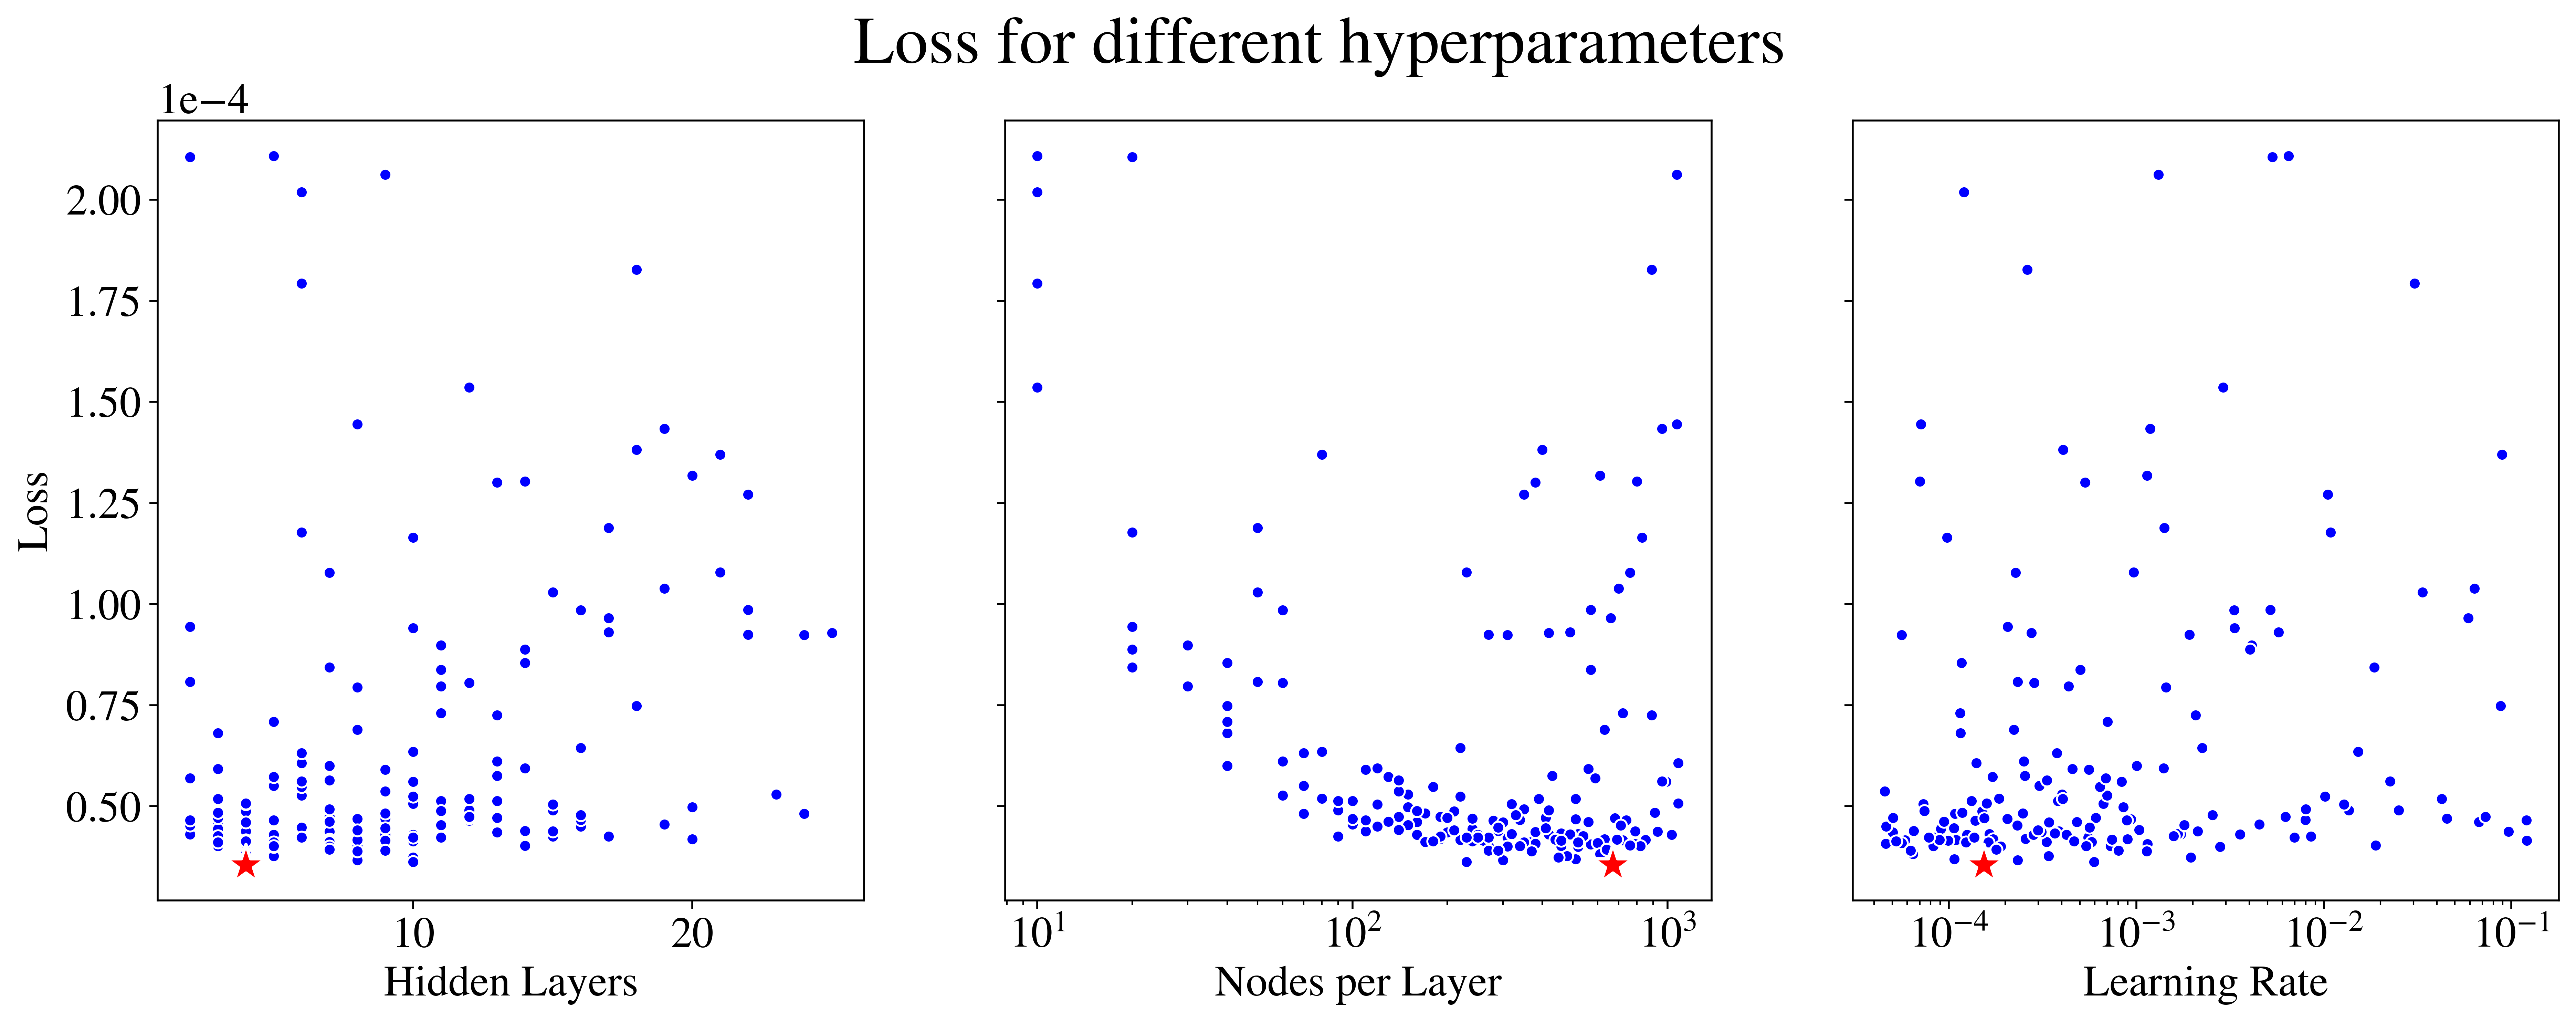

In [321]:
cols = trials_df.columns.drop(["Loss", "LogLoss", "Last Layer Activation function", "weights", "history"])

fig, ax = plt.subplots(1,len(cols), sharey=True, figsize=(18,6), dpi=500)

fig.suptitle("Loss for different hyperparameters", size=28)

for i, hyperParam in enumerate(cols):
    #ax[i].set_title(hyperParam)
    sns.scatterplot(data=trials_df, x=hyperParam, y="Loss", ax=ax[i], color="blue", marker=".", s=100)
    sns.scatterplot(data=trials_df.loc[[idx_best],:], x=hyperParam, y="Loss", ax=ax[i], marker="*", color="red", s=300)
    
    if hyperParam in ["Learning Rate", "Nodes per Layer"]:
        ax[i].set_xscale("log")
    
    
    #Show trial index
    #[ax[i].annotate(idx, (trials_df.loc[idx,hyperParam], trials_df.loc[idx,"Loss"]), fontsize=7) for idx in trials_df.reset_index()["index"].values]
    
#ax[-1].set_yscale("log")

ax[-1].ticklabel_format(style='sci',scilimits=(0,0),axis='y')

#plt.savefig(f"Figures/lossHyperParams_FFNN_{datasetName}.pdf", format="pdf", pad_inches=0)
plt.show()

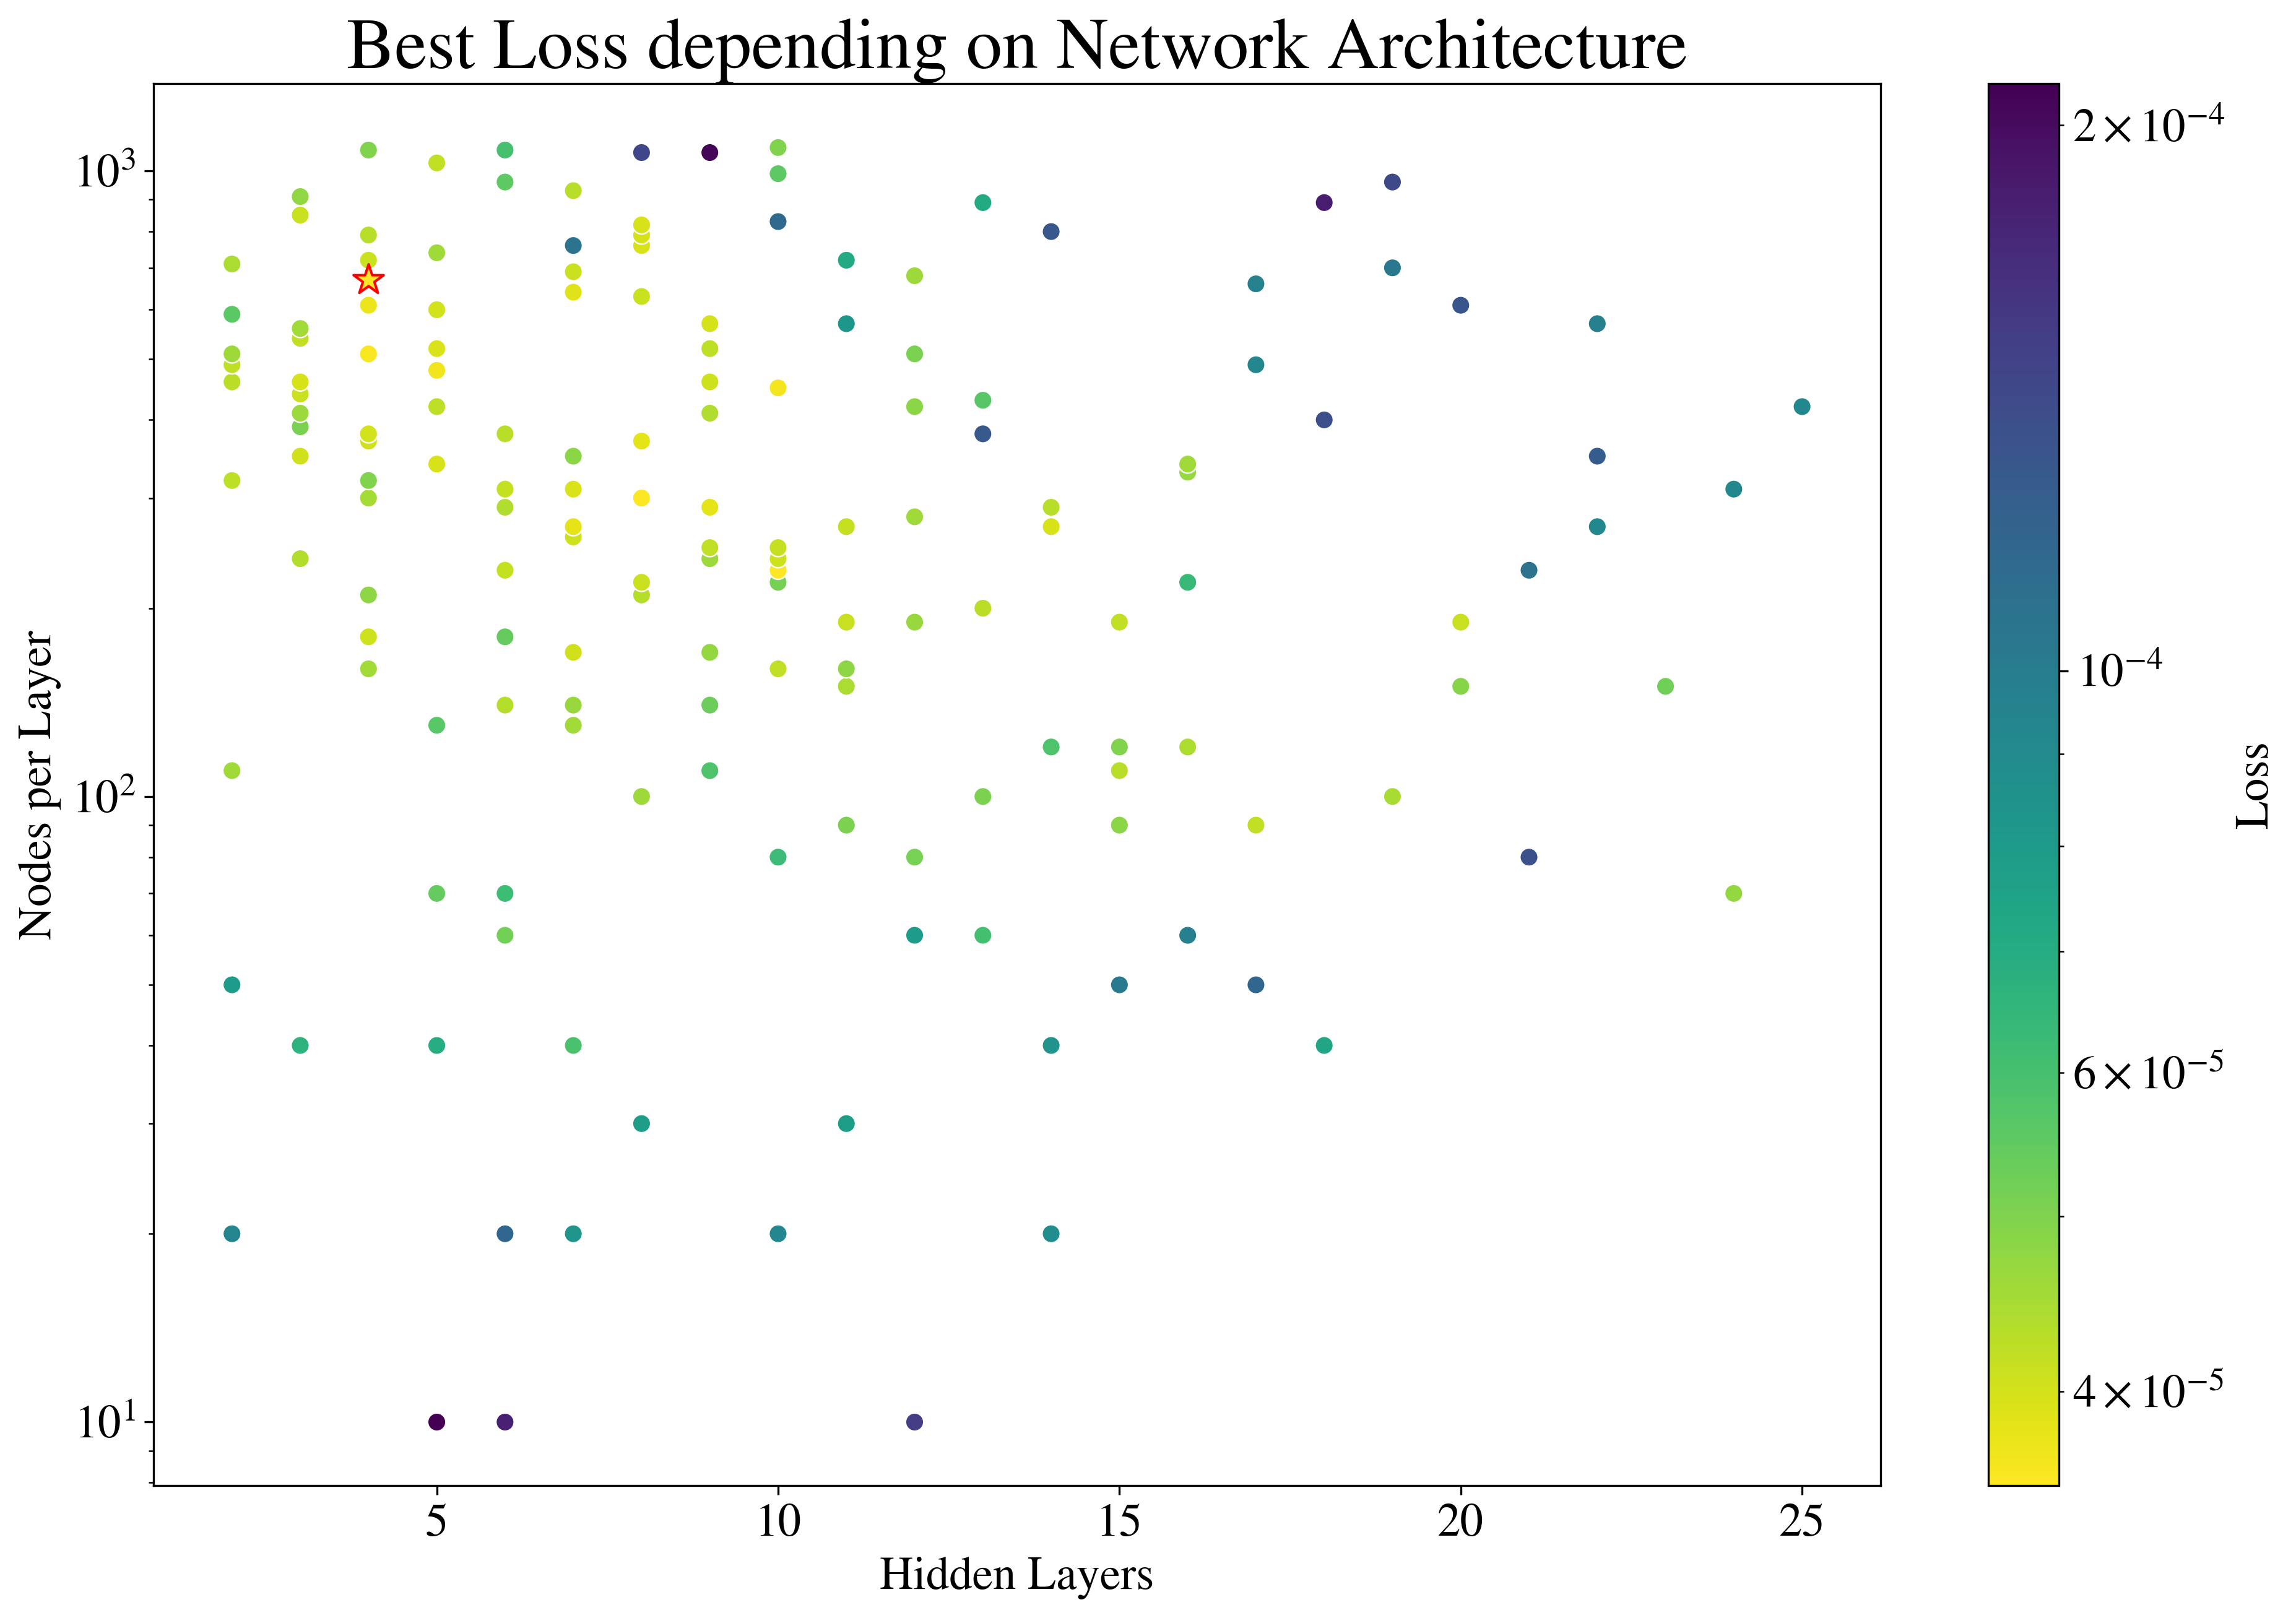

In [323]:
tmp_df = trials_df[["Loss", "LogLoss", "Hidden Layers", "Nodes per Layer"]]
tmp_df = tmp_df.loc[tmp_df.groupby(["Hidden Layers", "Nodes per Layer"])["Loss"].idxmin()]

plt.figure()
plt.title(r"Best Loss depending on Network Architecture", size=28)
sns.scatterplot(data=tmp_df.drop(idx_best, axis=0), x="Hidden Layers", y="Nodes per Layer", hue="LogLoss", palette="viridis_r", s=50);
sns.scatterplot(data=tmp_df.loc[[idx_best],:], x="Hidden Layers", y="Nodes per Layer", hue="LogLoss", palette="viridis_r", marker="*", edgecolor="red", s=150);
plt.yscale("log")

#colorbar
norm = matplotlib.colors.LogNorm(tmp_df['Loss'].min(), tmp_df['Loss'].max())
sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
sm.set_array([])
ax = plt.gca()
ax.get_legend().remove()
cbar = plt.colorbar(sm, ax=ax)
cbar.ax.set_ylabel(r"Loss", rotation=90)

#Show trial index
#[plt.annotate(idx, (tmp_df.loc[idx,"Hidden Layers"], tmp_df.loc[idx,"Nodes per Layer"]), fontsize=7) for idx in tmp_df.reset_index()["index"].values]

#plt.savefig(f"Figures/lossArchitecture_FFNN_{datasetName}.pdf", format="pdf", pad_inches=0)
plt.show()

___
# Best Model


Best Trial:


,Loss,Hidden Layers,Nodes per Layer,Learning Rate
17,0.000039,5.0,670.0,0.025581





Model: "Classical_FFNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 670)               2010      
_________________________________________________________________
hidden_2 (Dense)             (None, 670)               449570    
_________________________________________________________________
hidden_3 (Dense)             (None, 670)               449570    
_________________________________________________________________
hidden_4 (Dense)             (None, 670)               449570    
_________________________________________________________________
hidden_5 (Dense)             (None, 670)               449570    
_________________________________________________________________
output (Dense)               (None, 1)                 671       
Total params: 1,800,961
Trainable params: 1,800,961
Non-trainable params: 0
_______________________________________

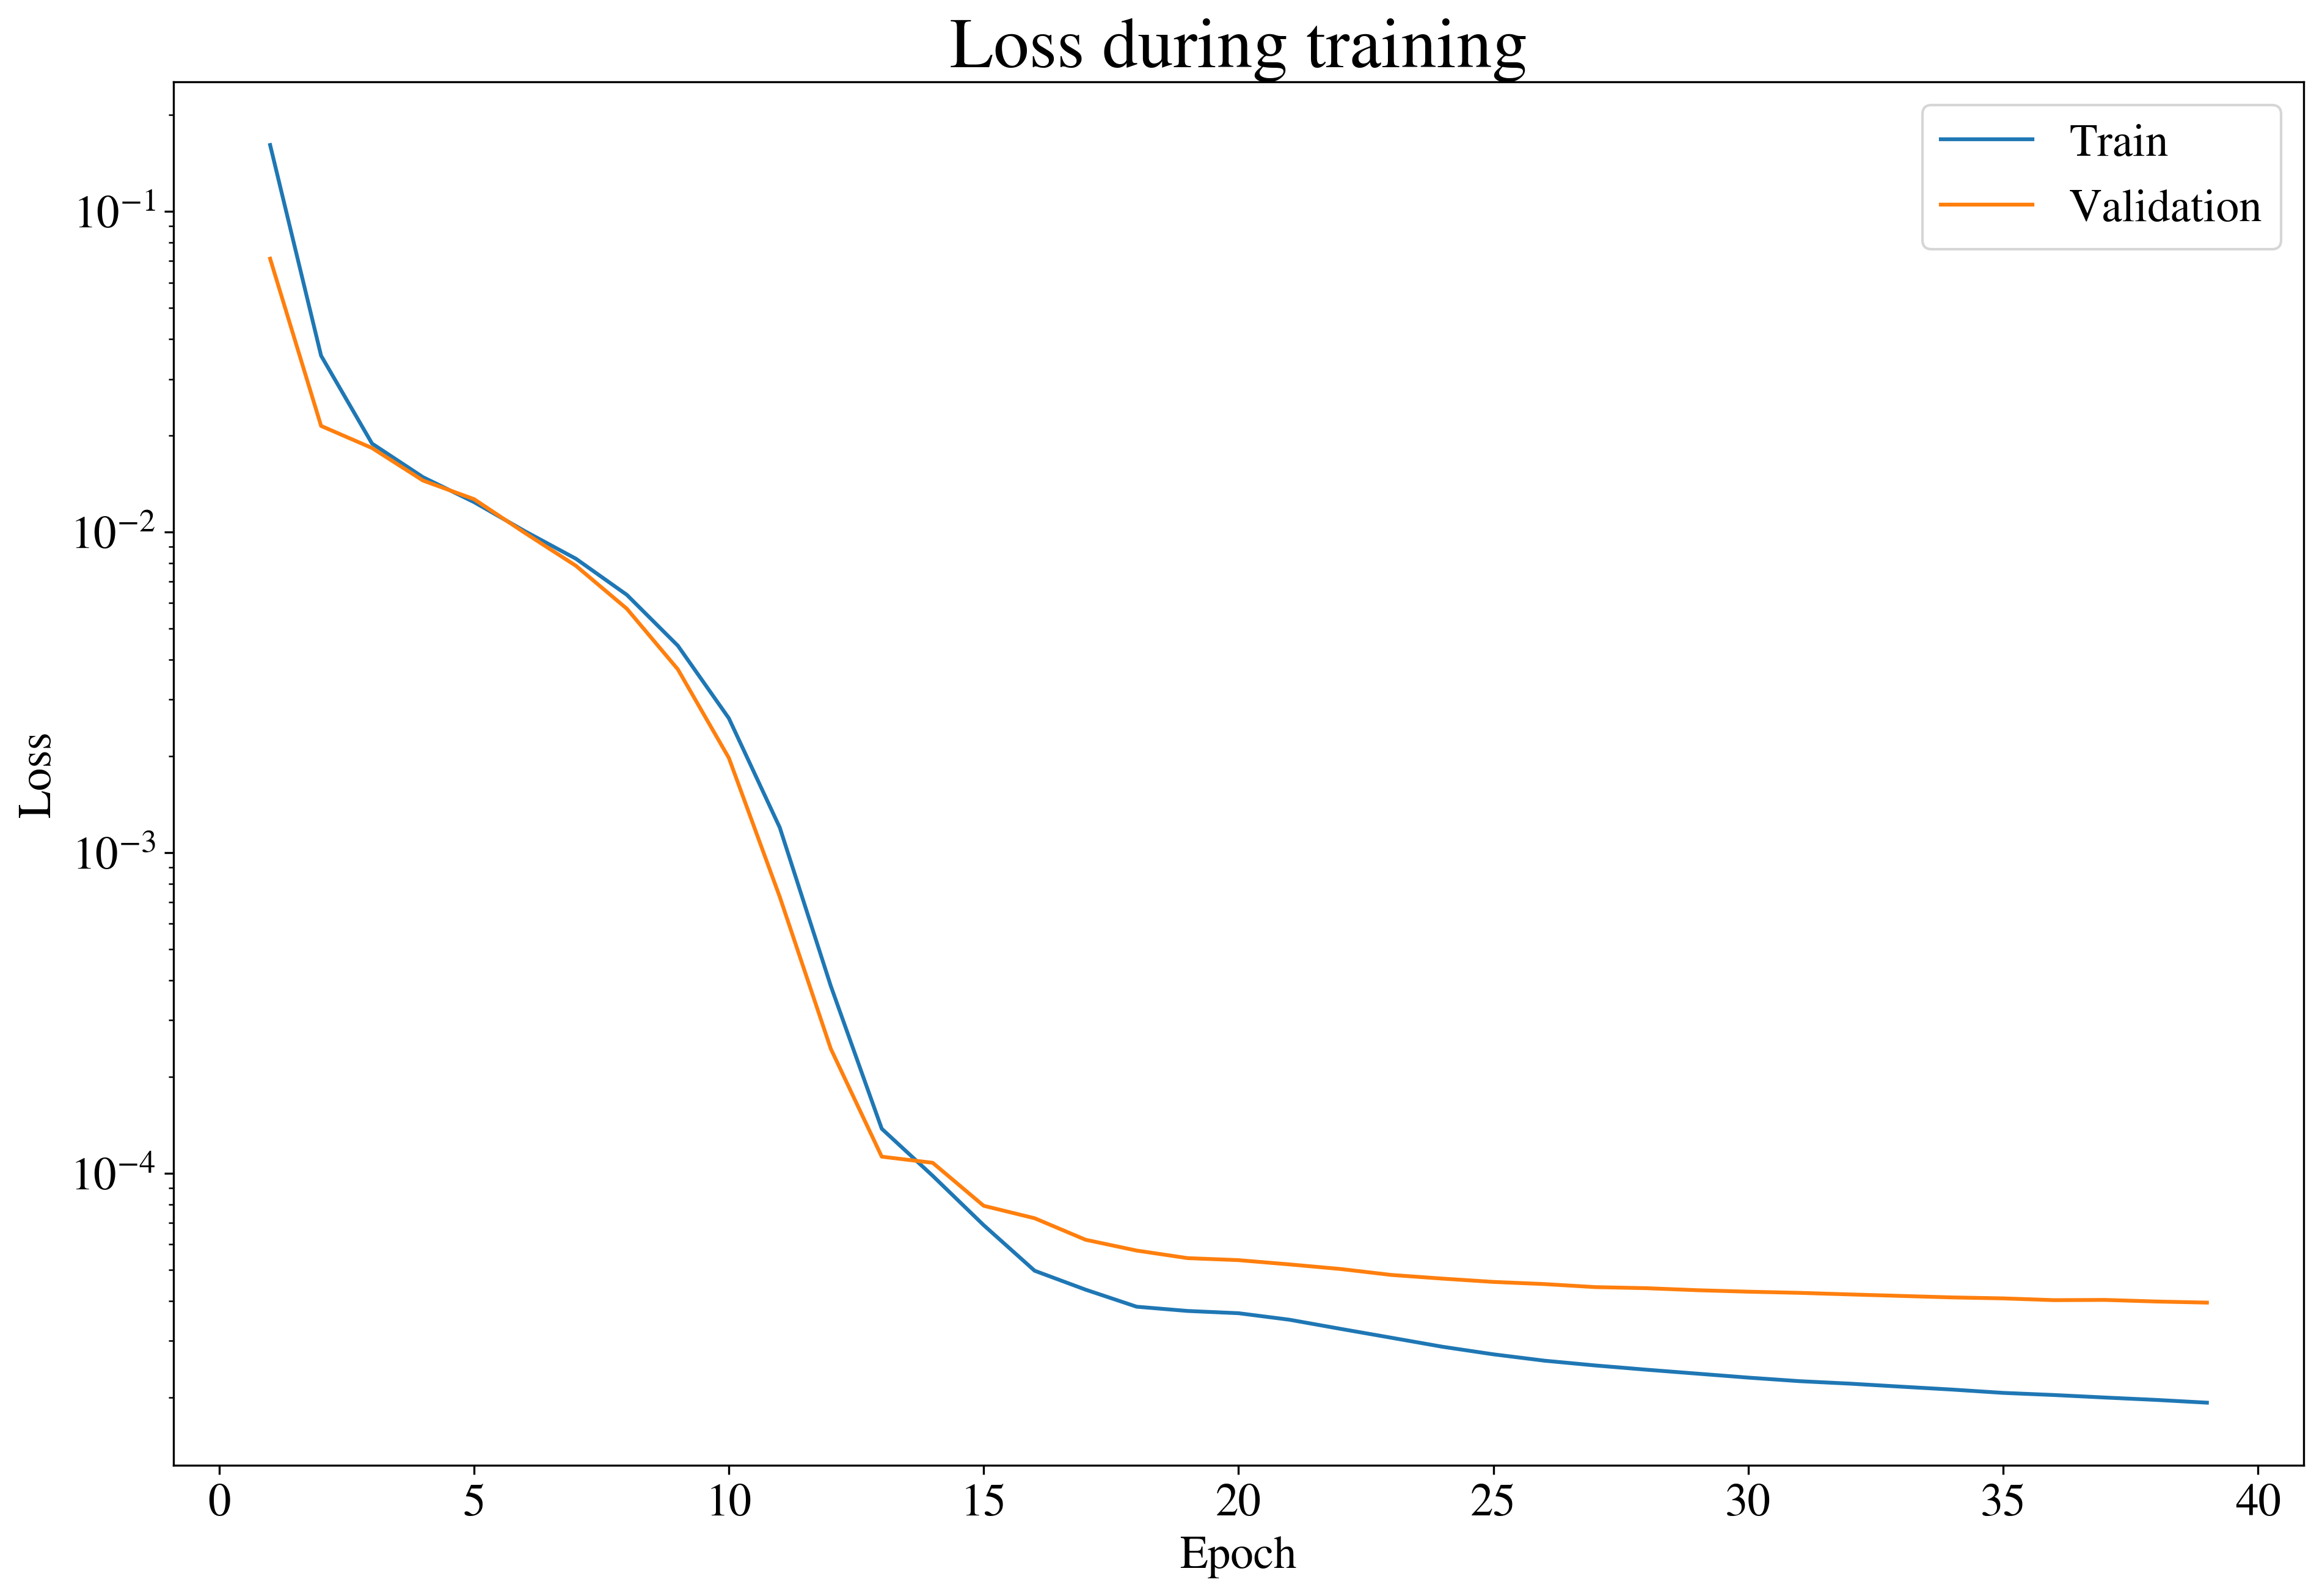

In [100]:
print("\nBest Trial:")
display(trials_df.loc[[idx_best], ["Loss", "Hidden Layers", "Nodes per Layer", "Learning Rate"]])
print("\n\n")

model = create_model(hiddenLayers=int(trials_df.loc[idx_best,"Hidden Layers"]), 
                     nodesPerLayer=int(trials_df.loc[idx_best,"Nodes per Layer"]), 
                     lastLayerActivation=trials_df.loc[idx_best,"Last Layer Activation function"])

compile_model(model, trials_df.loc[idx_best,"Learning Rate"], verbose=1)

#Set trained weights
model.set_weights(trials_df.loc[idx_best,"weights"])
history = trials_df.loc[idx_best,"history"]

#Retrain model
#history = fit_model(model, train_dataset, val_dataset, epochs=1000, verbose=1).history


plt.figure()
plt.plot(range(1, len(np.array(history["loss"]))+1), np.array(history["loss"]), label="Train")
plt.plot(range(1, len(np.array(history["loss"]))+1), np.array(history["val_loss"]), label="Validation")
plt.title("Loss during training", size=28)
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.yscale("log")
plt.legend()
#plt.savefig(f"Figures/lossHistory_FFNN_{datasetName}.pdf", format="pdf", pad_inches=0)
plt.show()

## Best Model Evaluation

In [97]:
test_loss, test_absError = model.evaluate(test_dataset, verbose=0)

print( f"Test Loss = {test_loss}\nTest Mean Absolute Error = {test_absError}")

Test Loss = 0.0014104978181421757
Test Mean Absolute Error = 0.028943639248609543


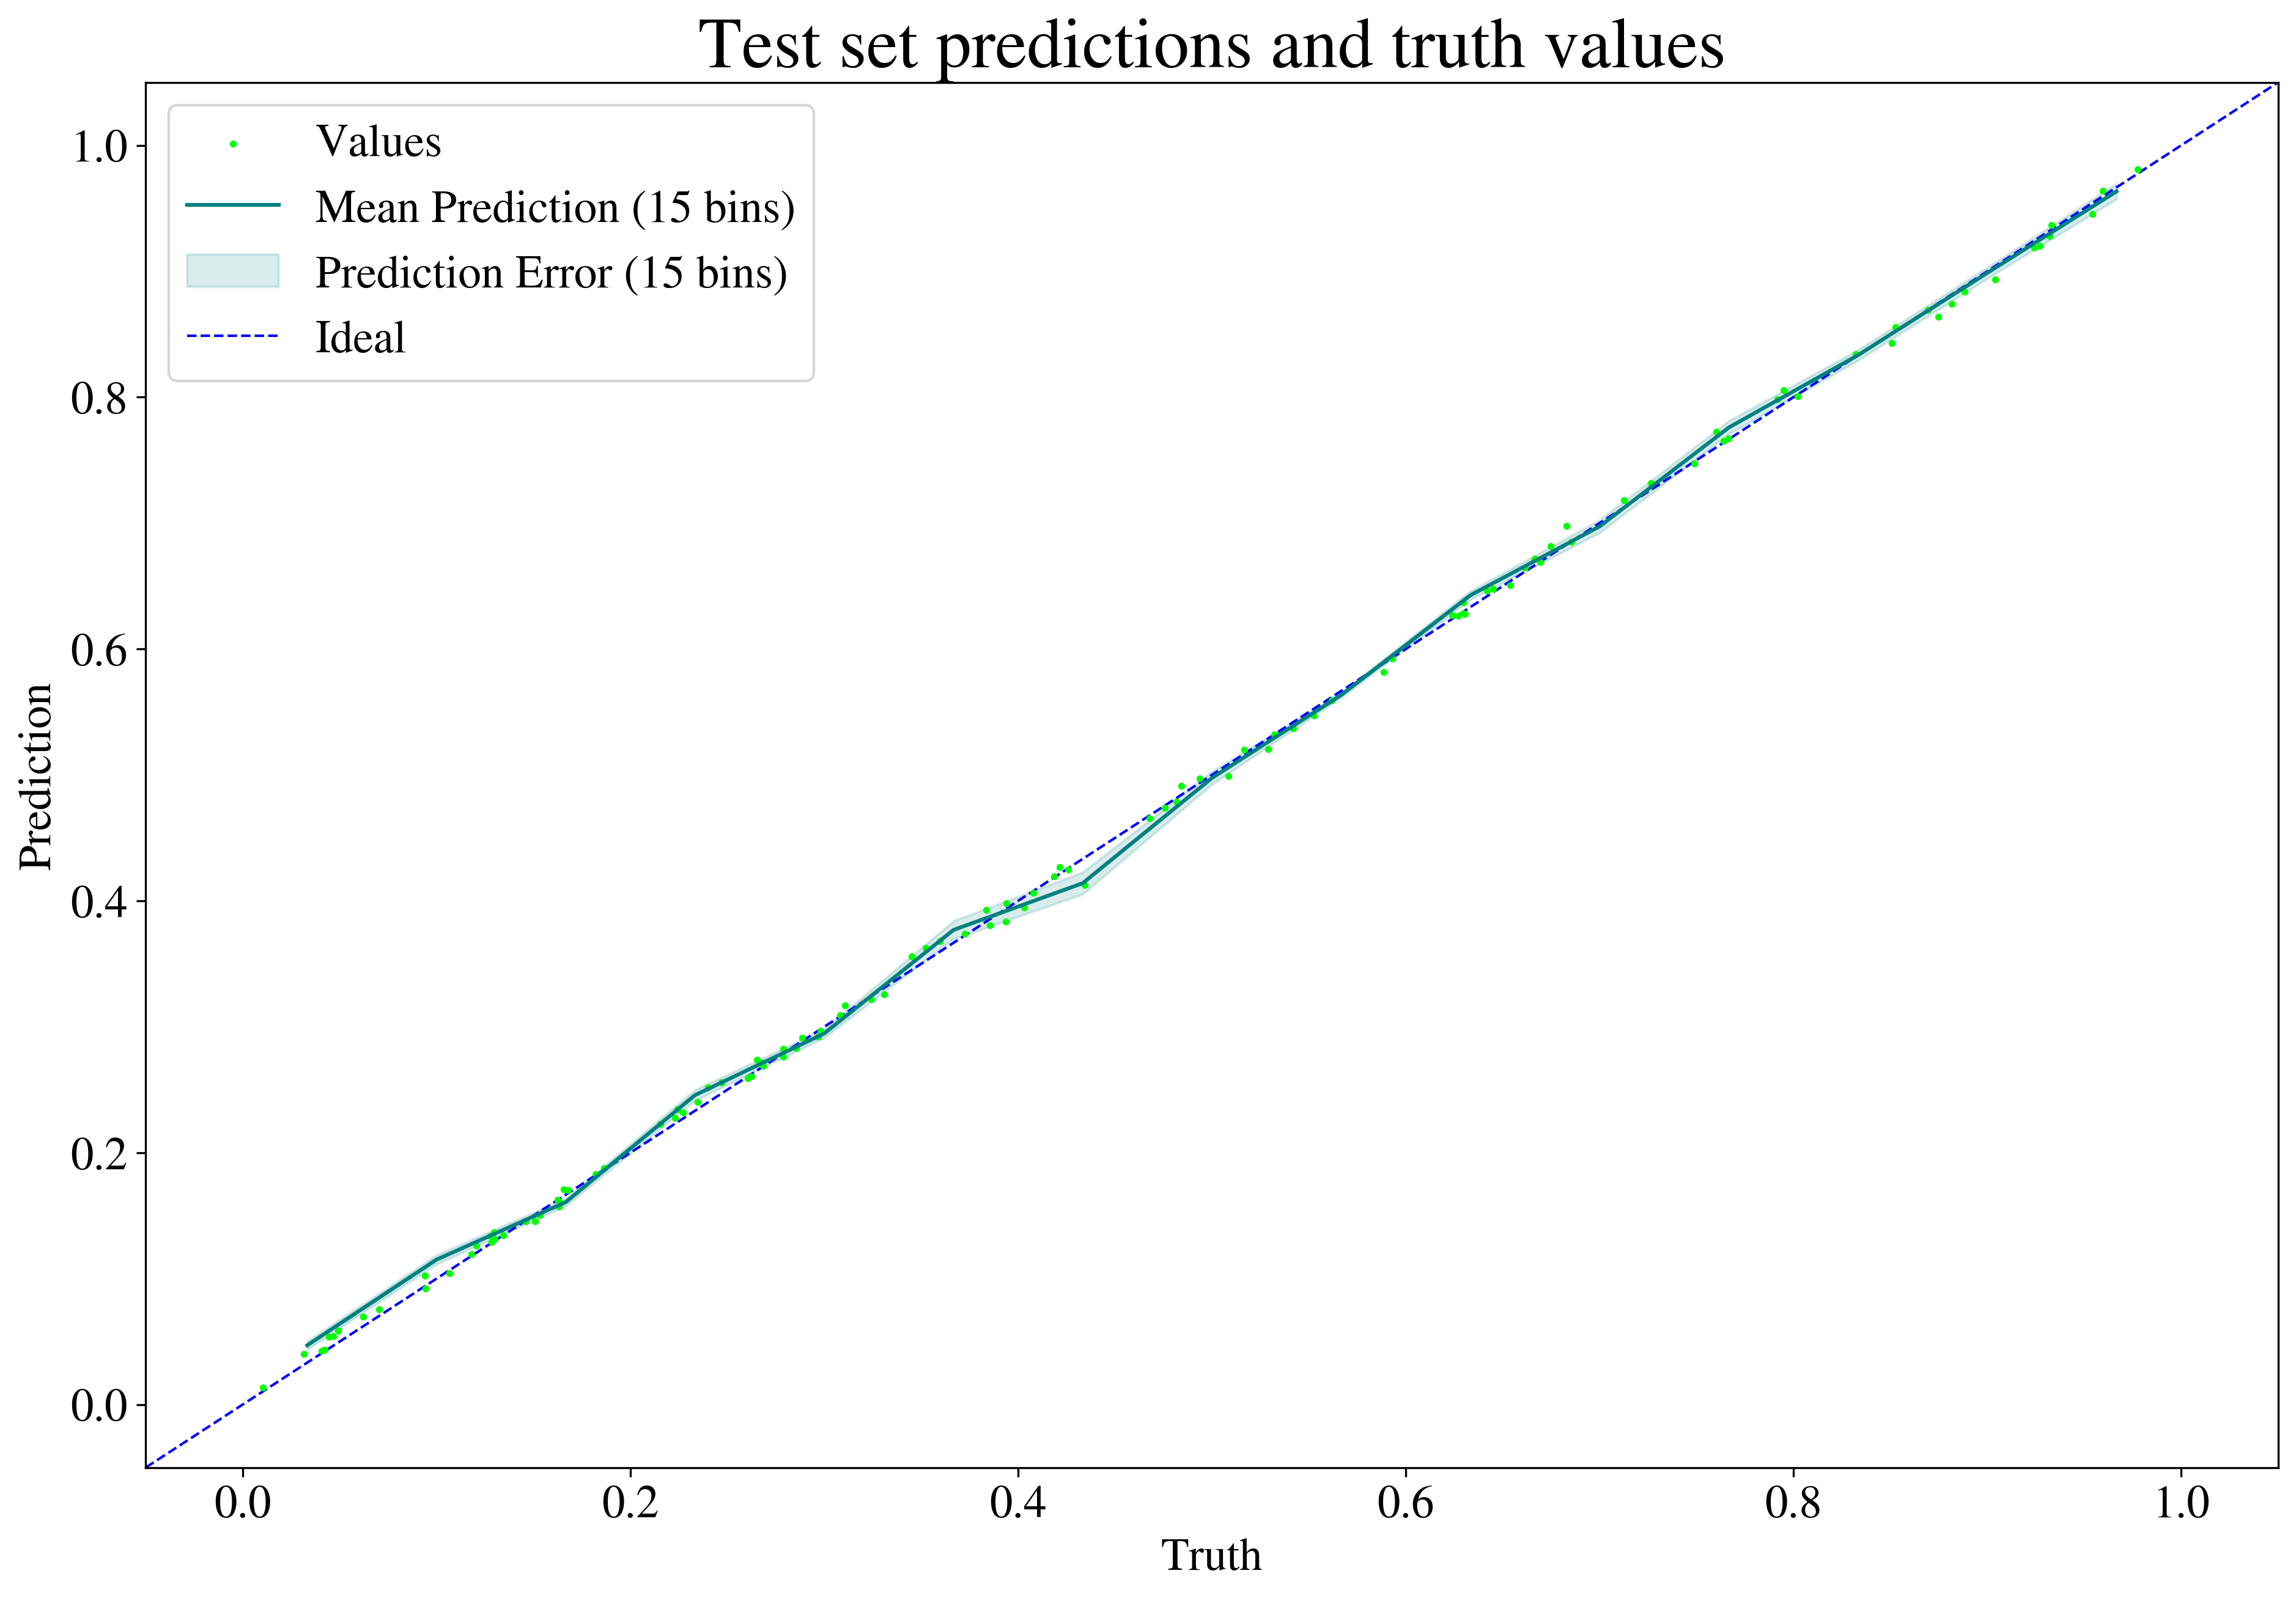

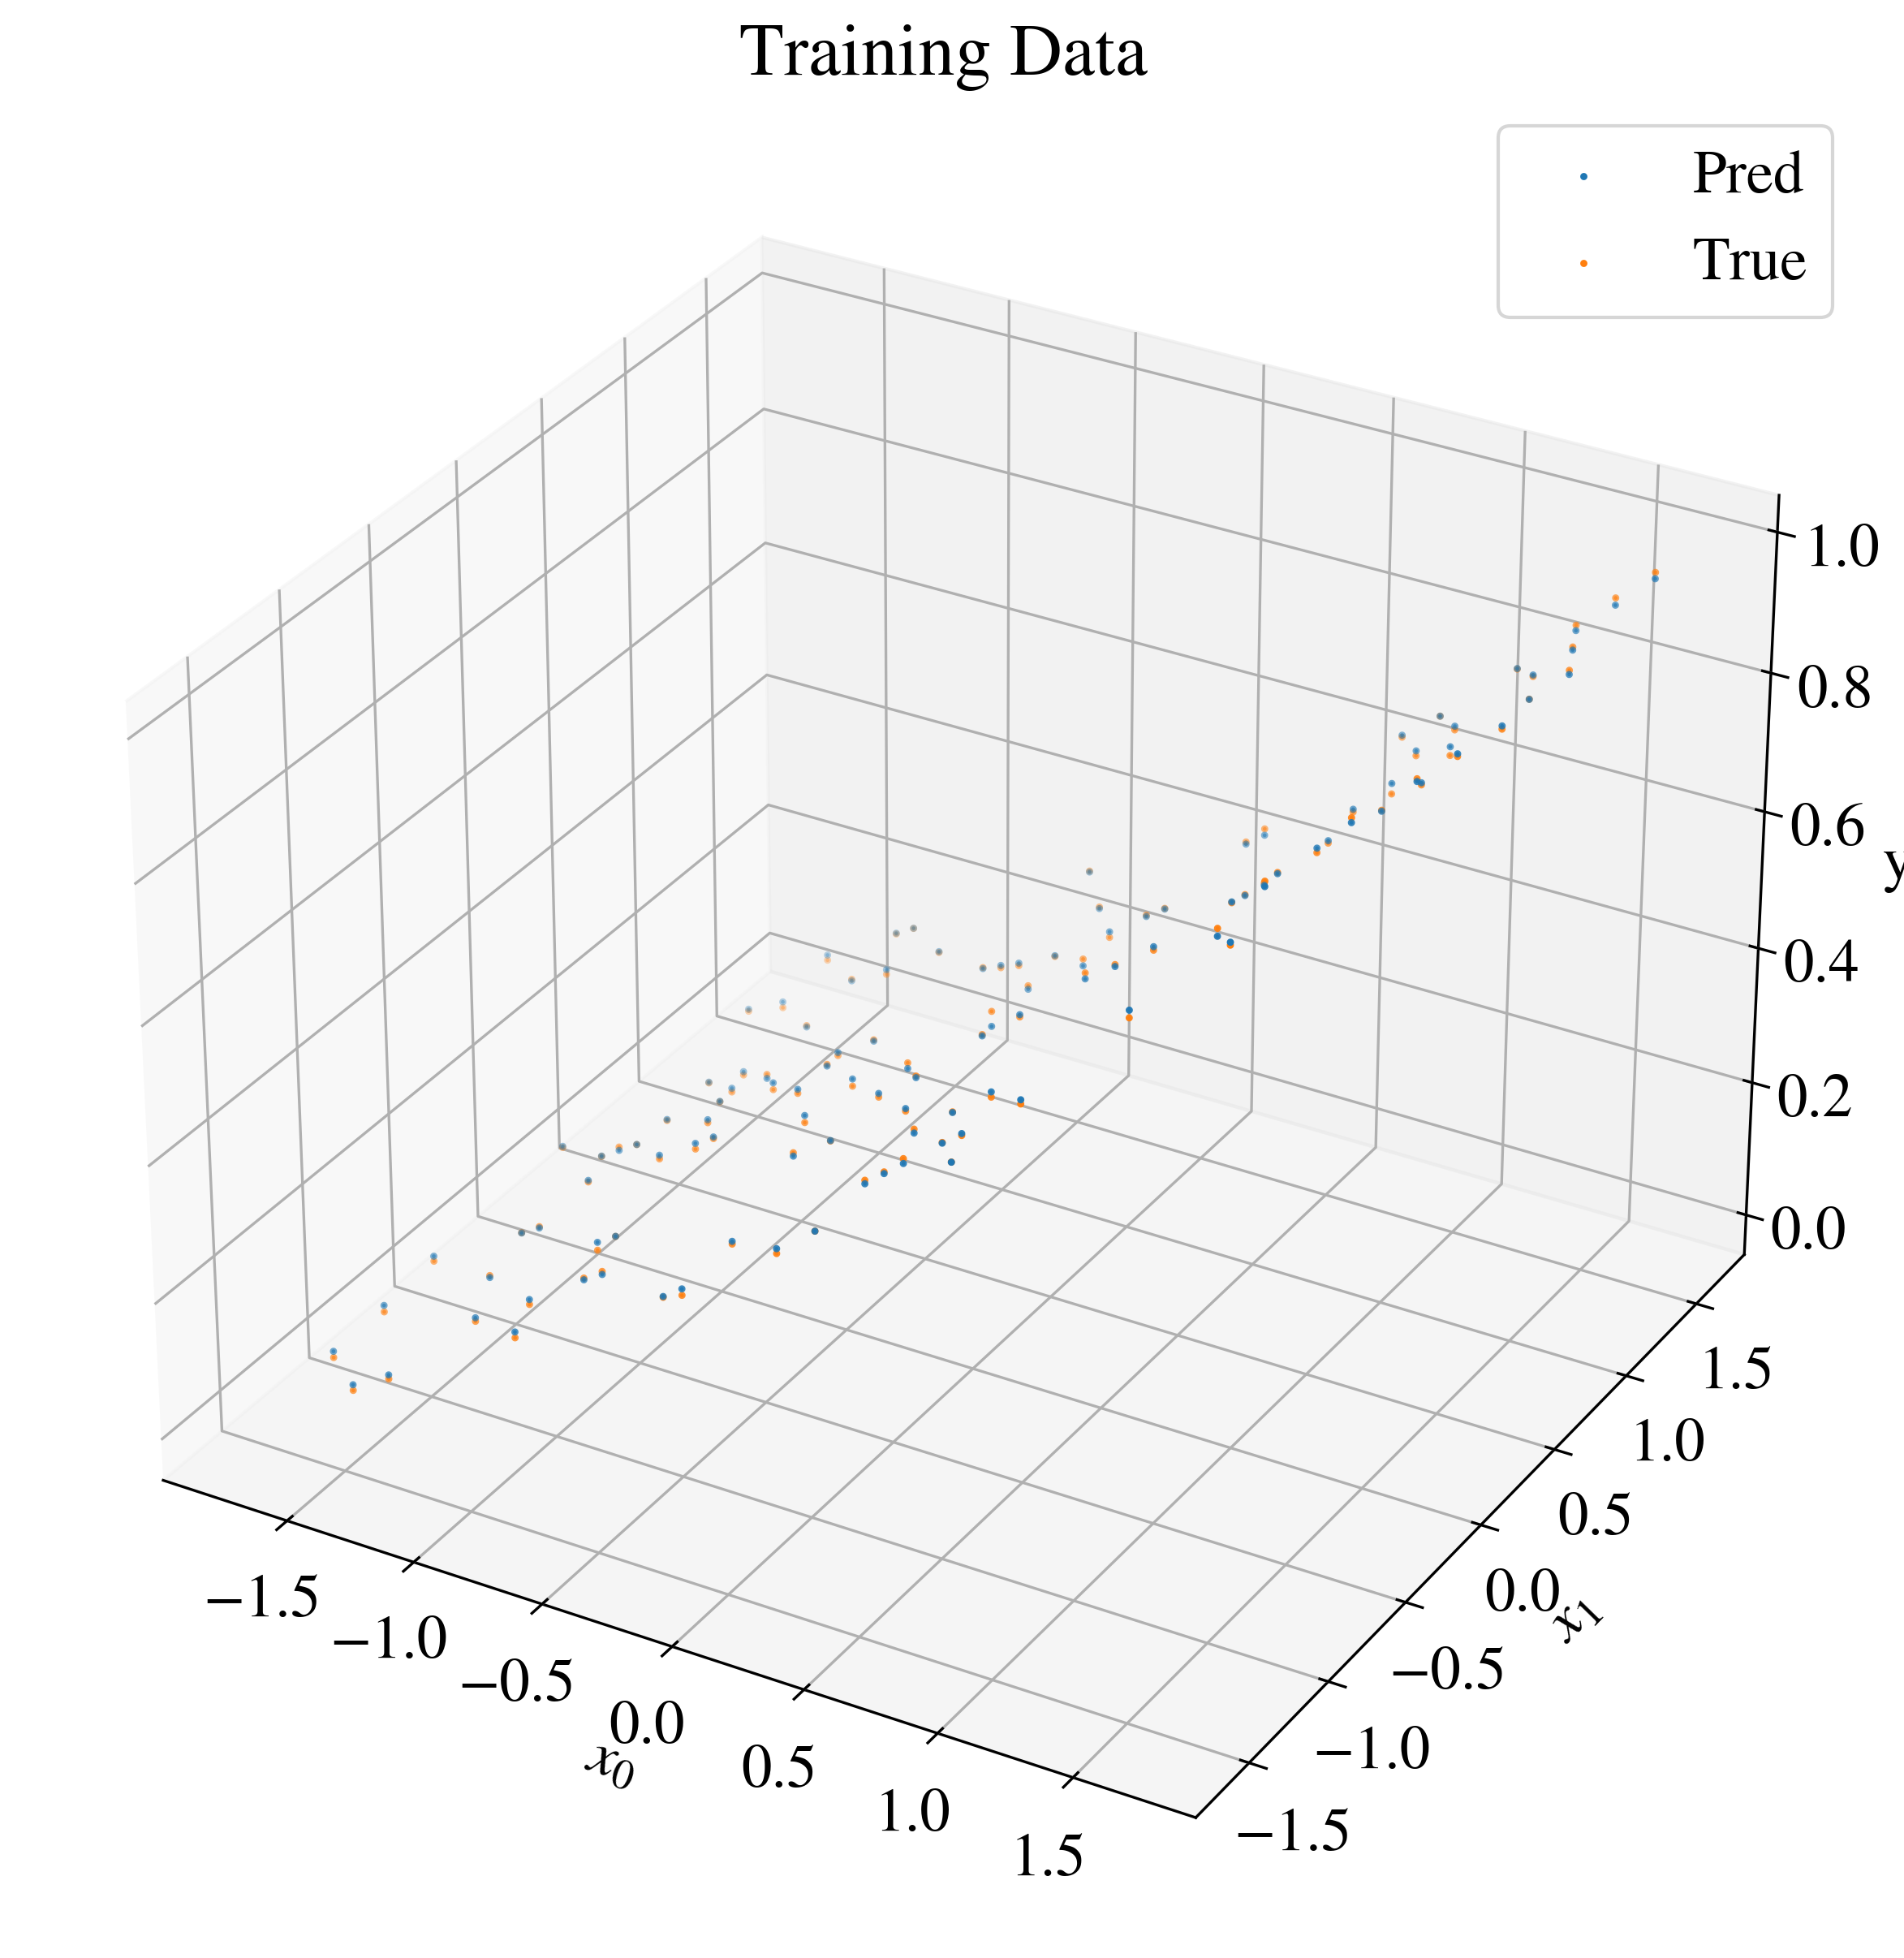

In [101]:
nBins=15
yX = [y_test, X_test]

y_pred = model.predict(yX[1])

bins = np.linspace(0,1,nBins+1)
#bins = np.concatenate([np.linspace(0, .3, int(0.6*nBins), endpoint=False),np.linspace(.3,1, int(0.4*nBins)+1, endpoint=True)]) #for cars data
x = (bins[:-1] + bins[1:])/2
mean = binStats(yX[0], y_pred[:,0], "mean", bins=bins).statistic
std = binStats(yX[0], y_pred[:,0]-yX[0], "std", bins=bins).statistic


plt.figure()
plt.title(f"Test set predictions and truth values", size=28)

plt.axline((0,0), (1,1), color="blue", lw=1, ls="dashed", label="Ideal")

plt.plot(x, mean, color="teal", lw=1.5, label=f"Mean Prediction ({nBins} bins)", zorder=3)
plt.fill_between(x, mean-std, mean+std, color="teal", alpha=0.15, label=f"Prediction Error ({nBins} bins)")

plt.scatter(yX[0], y_pred, s=3, color='lime',label="Values", zorder=2)


plt.xlabel('Truth')
plt.ylabel('Prediction')

plt.legend()

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

#plt.savefig(f"Figures/true_pred_scatter_FFNN_{datasetName}.pdf", format="pdf", pad_inches=0)

plt.show()

if INPUT_SHAPE[0] == 1:
    plt.figure()
    plt.title("Test Set Predictions and Truth Values", size=28)
    
    plt.scatter(X_test, y_test, label="True", s=3)
    plt.scatter(X_test, model.predict(X_test), label="Pred", s=3)

    plt.xlabel("x")
    plt.ylabel("y")

    plt.legend()
    
    #plt.savefig(f"Figures/true_pred_plot_FFNN_{datasetName}.pdf", format="pdf", pad_inches=0)

    
    

if INPUT_SHAPE[0] == 2:
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.scatter(X_test[:,0], X_test[:,1], y_pred, s=5, marker='.', label="Pred")
    ax.scatter(X_test[:,0], X_test[:,1], y_test, s=5, marker='.', label="True")
    ax.set_xlabel(r"$x_0$")
    ax.set_ylabel(r"$x_1$")
    ax.set_zlabel("y")
    plt.legend()
    plt.title("Training Data")




___
#### Extrapolation for CO2 data

In [102]:
#for 2dim CO2 data

def rescaleInput(X, yearStart=1974):
    x = np.unique(X[:,0])
    deltaYear = x[1]-x[0]
    yearDict = dict(zip(x,(x - x.min())/deltaYear + 1974))

    x = np.unique(X[:,1])
    deltaMonth = x[1]-x[0]
    
    monthDict = dict(zip(x,(x - x.min())/deltaMonth/len(x)*12))
    
    rescaled = []
    for row in X:
        rescaled.append([yearDict[row[0]],monthDict[row[1]]])

    return np.array(rescaled)

def rescaledInput_to_timeDecimal(X):
    timeDecimal = []
    for row in X:
        timeDecimal.append(row[0] + row[1]/12)
        
    return timeDecimal



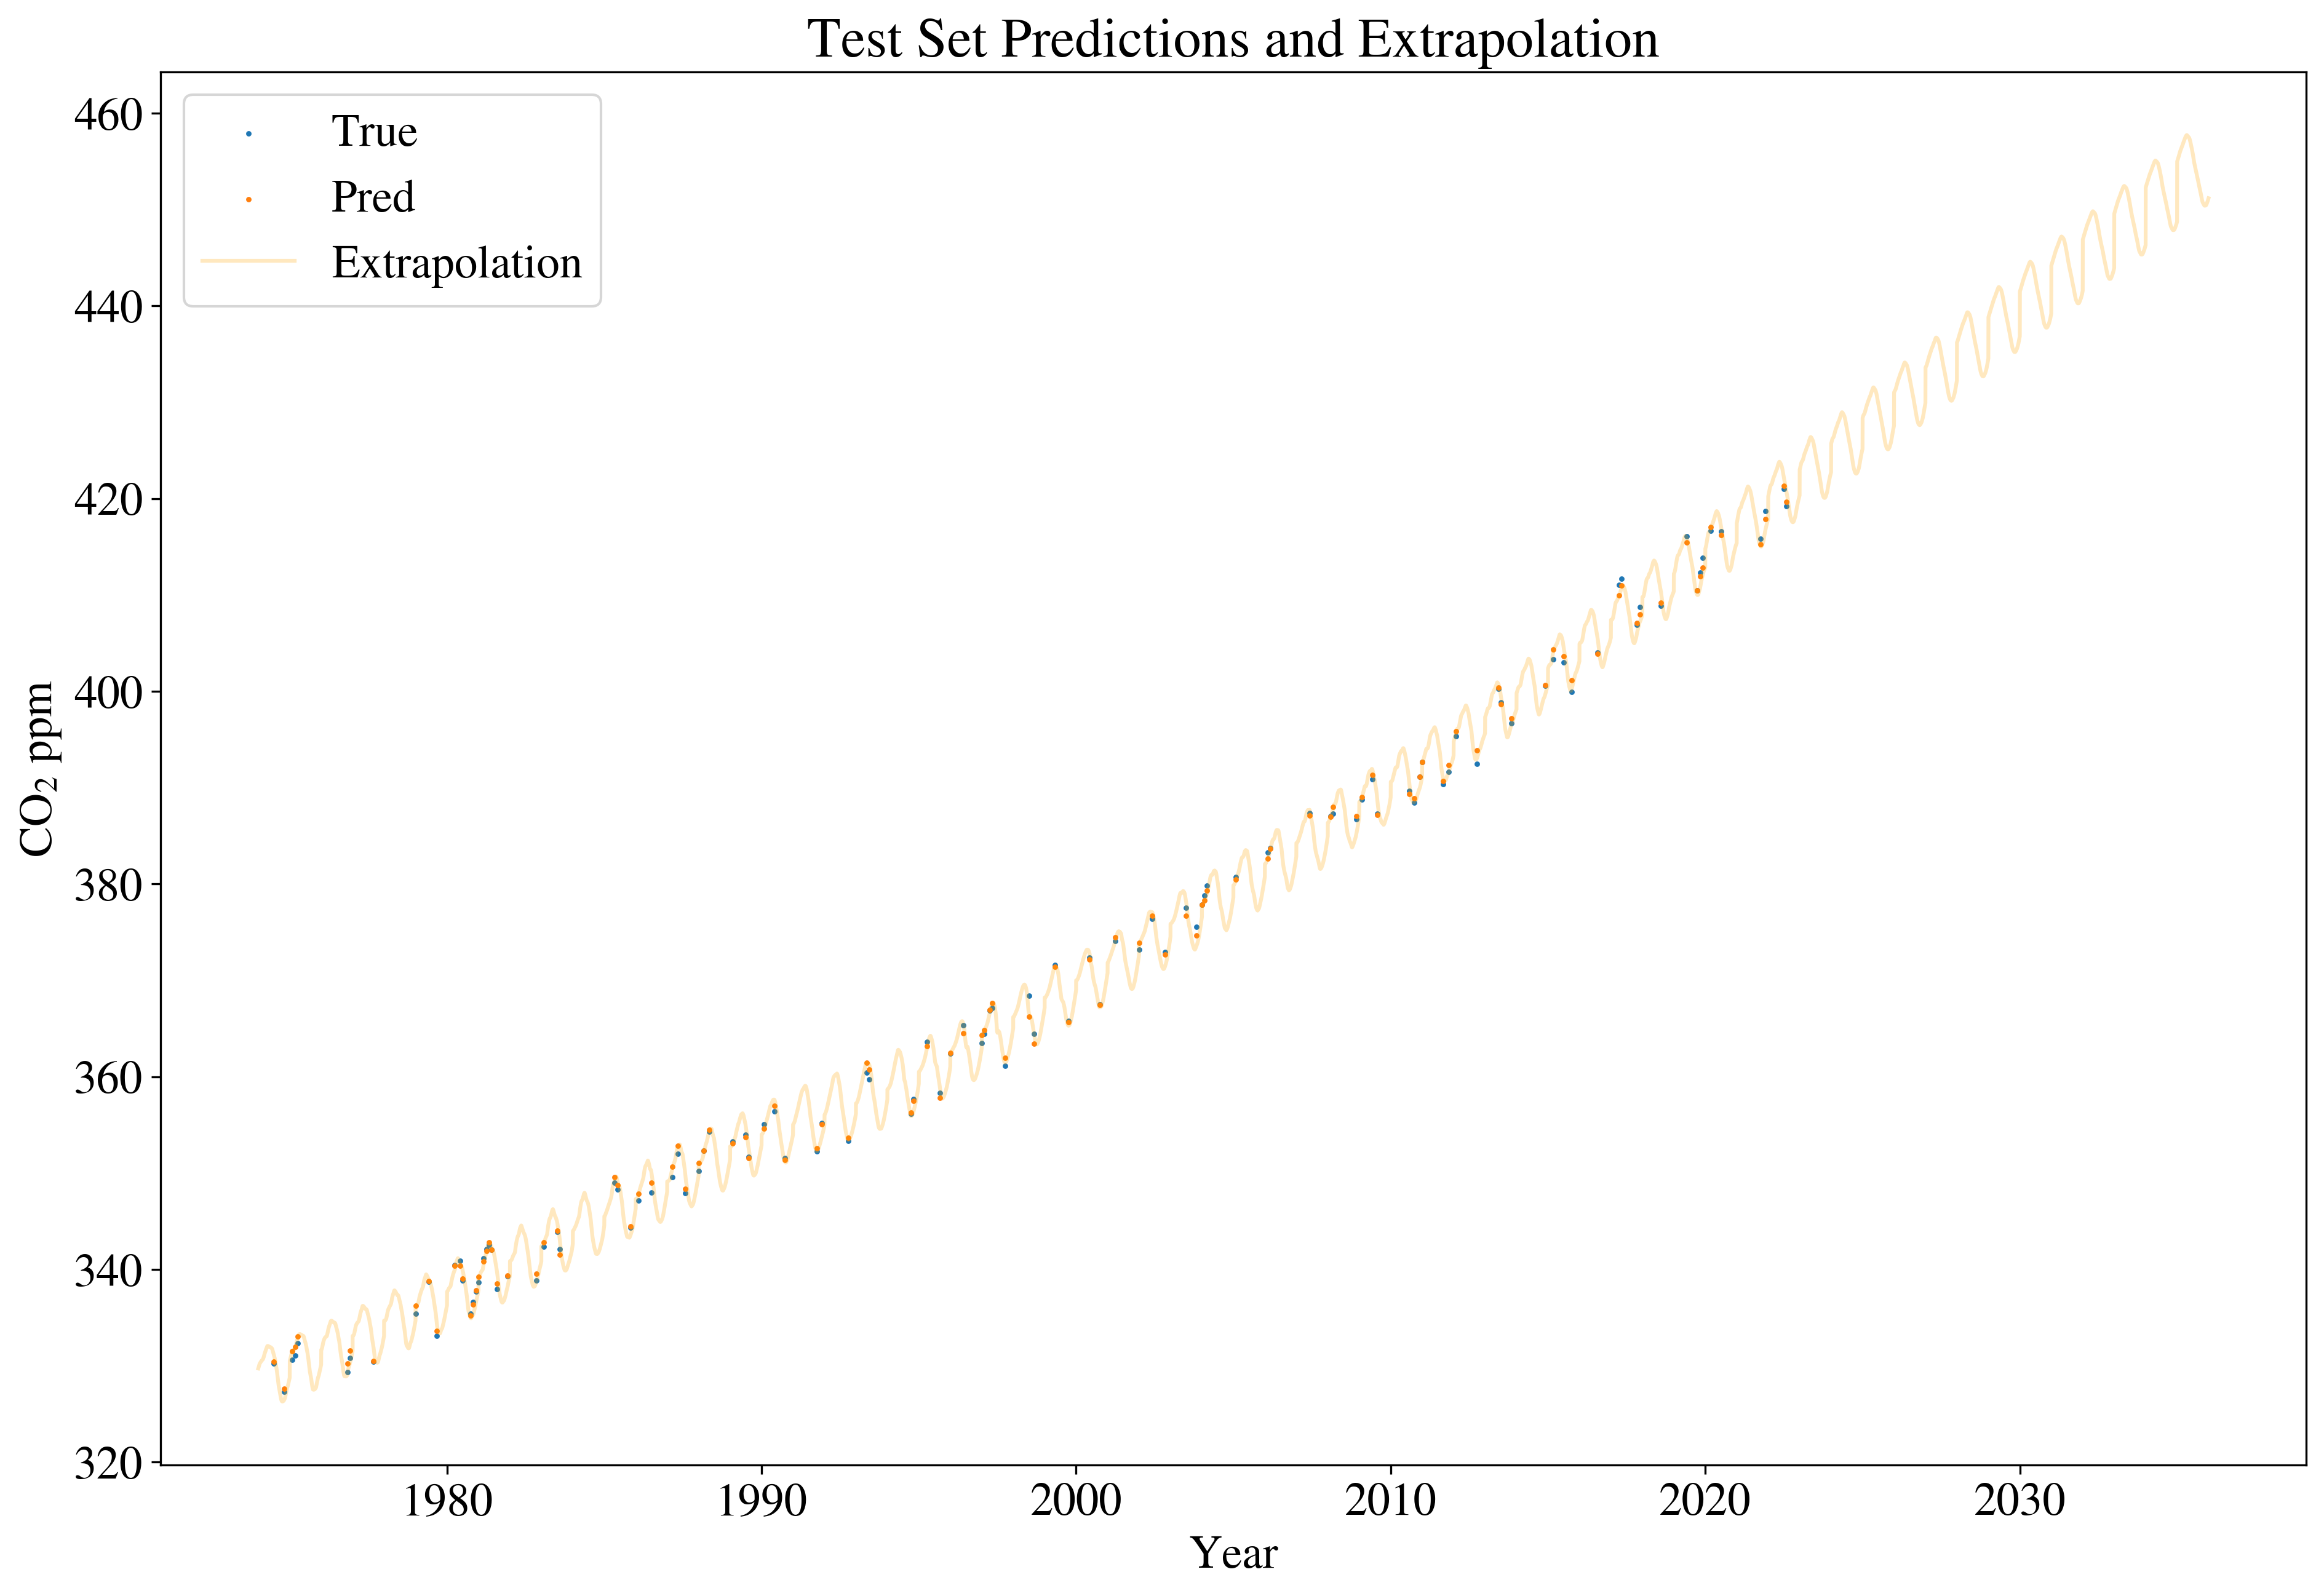

In [103]:
y_pred = model.predict(X_test)

y_plot_test = (y_test-y_test.min())/(y_test.max()-y_test.min())*(420.97-327.3) + 327.3
y_plot_pred = (y_pred-y_test.min())/(y_test.max()-y_test.min())*(420.97-327.3) + 327.3

if INPUT_SHAPE[0] == 1:
    x_plot_test = (X_test-X_test.min())/(X_test.max()-X_test.min())*(2022.832877 - 1974.328767) + 1974.328767
    x_extrapolate = [[i] for i in np.linspace(X_test.min(), X_test.max()+1, 1000)]
    y_extrapolate = (model.predict(x_extrapolate)-y_test.min())/(y_test.max()-y_test.min())*(420.97-327.3) + 327.3
    x_plot_extrapolate = (x_extrapolate-X_test.min())/(X_test.max()-X_test.min())*(2022.832877 - 1974.328767) + 1974.328767
    
    plt.figure()
    plt.title("Test Set Predictions and Extrapolation", size=28)
    
    plt.plot(x_plot_extrapolate, y_extrapolate, color="orange", alpha=0.25, label="Extrapolation")
    plt.scatter(x_plot_test, y_plot_test, s=5, marker='.', label="True")   
    plt.scatter(x_plot_test, y_plot_pred, s=5, marker='.', label="Pred")
    
    plt.xlabel("Year")
    plt.ylabel(r"CO${}_2$ ppm")

    plt.legend()

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,2,0]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])


    #plt.savefig(f"Figures/true_pred_plot_FFNN_{datasetName}.pdf", format="pdf", pad_inches=0)


if INPUT_SHAPE[0] == 2:
    deltaYear = np.unique(X_test[:,0])[1] - np.unique(X_test[:,0])[0]
    deltaMonth = np.unique(X_test[:,1])[1] - np.unique(X_test[:,1])[0]

    x_extrapolate = []
    for i in np.arange(X_train[:,0].min(), X_train[:,0].max()+1, deltaYear):
        for j in np.linspace(X_train[:,1].min(), X_train[:,1].max(), 1000, endpoint=False):
            x_extrapolate.append([i,j])
    x_extrapolate = np.array(x_extrapolate)
    
    y_extrapolate = (model.predict(x_extrapolate)-y_test.min())/(y_test.max()-y_test.min())*(420.97-327.3) + 327.3
    x_plot_extrapolate = rescaledInput_to_timeDecimal(rescaleInput(x_extrapolate))

    x_plot_test = rescaledInput_to_timeDecimal(rescaleInput(X_test))

    fig = plt.figure()
    plt.title("Test Set Predictions and Truth Values", size=28)

    plt.plot(x_plot_extrapolate, y_extrapolate, color="orange", alpha=0.25, label="Extrapolation")
    plt.scatter(x_plot_test, y_plot_test, s=5, marker='.', label="True")   
    plt.scatter(x_plot_test, y_plot_pred, s=5, marker='.', label="Pred")

    plt.xlabel("Year")
    plt.ylabel("CO${}_2$ ppm")
    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [1,2,0]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    plt.title("Test Set Predictions and Extrapolation")

    #plt.savefig(f"Figures/true_pred_plot_FFNN_{datasetName}.pdf", format="pdf", pad_inches=0)